In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/欧元-美元.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['欧元/美元'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,欧元/美元,美元指数
2025-12-03,NaN,NaN
2025-12-04,NaN,NaN
2025-12-05,NaN,NaN
2025-12-08,NaN,NaN
2025-12-09,NaN,NaN


In [5]:
# 尝试多个可能的文件路径
file_paths = [
    os.path.expanduser("~/Desktop/X-BASE/宏观经济/eta/美元指数_合并数据.xlsx"),
    os.path.expanduser("~/Desktop/弘则研究/Horizon-Insights/X-base/宏观经济/eta/美元指数_合并数据.xlsx"),
    os.path.expanduser("~/Downloads/hongze/宏观经济/eta/美元指数_合并数据.xlsx")
]

file_path = None
for path in file_paths:
    if os.path.isfile(path):  # 确保是文件而不是目录
        file_path = path
        break

if file_path is None:
    raise FileNotFoundError("未找到美元指数数据文件")

try:
    sheet1 = pd.read_excel(file_path, sheet_name='Sheet1')
    sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
    sheet1 = sheet1.drop(columns=['美元指数'])
    sheet1 = sheet1.dropna()
    sheet1 = sheet1.sort_values('Date', ascending=True)

except Exception as e:
    raise Exception(f"读取文件时出错: {str(e)}")

sheet1.head()

,Date,美元指数_预测
19,2025-10-28,102.7502
18,2025-10-29,103.3801
17,2025-10-30,103.3009
16,2025-10-31,103.4094
15,2025-11-03,103.4924


In [6]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '美元指数_预测']],
    on='Date',
    how='left'
)
sheet_daily['美元指数'] = sheet_daily['美元指数'].fillna(sheet_daily['美元指数_预测'])
sheet_daily = sheet_daily.drop(columns=['美元指数_预测'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2020-01-01')]
sheet_daily = sheet_daily.set_index('Date')


In [7]:
# 先删除所有列都为空的行
sheet_daily = sheet_daily.dropna(how='all')
last_valid_date = sheet_daily['欧元/美元'].last_valid_index()
sheet_daily = sheet_daily.loc[lambda df: ~((df.index <= last_valid_date) & (df['欧元/美元'].isna()))]

sheet_daily

,欧元/美元,美元指数
Date,,
2020-01-02,1.1193,96.8079
2020-01-03,1.1147,96.9082
2020-01-06,1.1194,96.6236
2020-01-07,1.1172,96.9621
2020-01-08,1.1115,97.3469
...,...,...
2025-11-18,NaN,103.1043
2025-11-19,NaN,103.2858
2025-11-20,NaN,103.2230


In [8]:
# 准备训练和测试数据
train_data = sheet_daily[sheet_daily.index <= last_day].copy().dropna()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily.index > last_day].copy()

feature_columns = '美元指数'
predict_column = '欧元/美元'


# 训练模型
model = LinearRegression()
X_train = train_data[feature_columns].values.reshape(-1, 1)
y_train = train_data[predict_column].values
model.fit(X_train, y_train)

# 在测试集上评估模型
X_test = test_data[feature_columns].values.reshape(-1, 1)
y_test = test_data[predict_column].values
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
# 计算评估指标
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('模型评估指标:')
print(f'均方误差 (MSE): {mse:.6f}')
print(f'均方根误差 (RMSE): {rmse:.6f}')
print(f'平均绝对误差 (MAE): {mae:.6f}')
print(f'R2分数: {r2:.6f}')

# 对未来数据进行预测
X_future = future_data[feature_columns].values.reshape(-1, 1)
future_predictions = model.predict(X_future)
future_data[f'{predict_column}_预测'] = future_predictions
train_data[f'{predict_column}_预测'] = y_pred_train
test_data[f'{predict_column}_预测'] = y_pred_test

模型评估指标:
均方误差 (MSE): 0.001751
均方根误差 (RMSE): 0.041846
平均绝对误差 (MAE): 0.040861
R2分数: -58.324317


In [9]:
future_data

,欧元/美元,美元指数,欧元/美元_预测
Date,,,
2025-10-29,NaN,103.3801,1.078129
2025-10-30,NaN,103.3009,1.078911
2025-10-31,NaN,103.4094,1.077839
2025-11-03,NaN,103.4924,1.077020
2025-11-04,NaN,103.4475,1.077463
2025-11-05,NaN,103.4370,1.077567
2025-11-06,NaN,103.3511,1.078415
2025-11-07,NaN,103.4378,1.077559
2025-11-10,NaN,103.4494,1.077444


调整差值: -0.08487135912798083


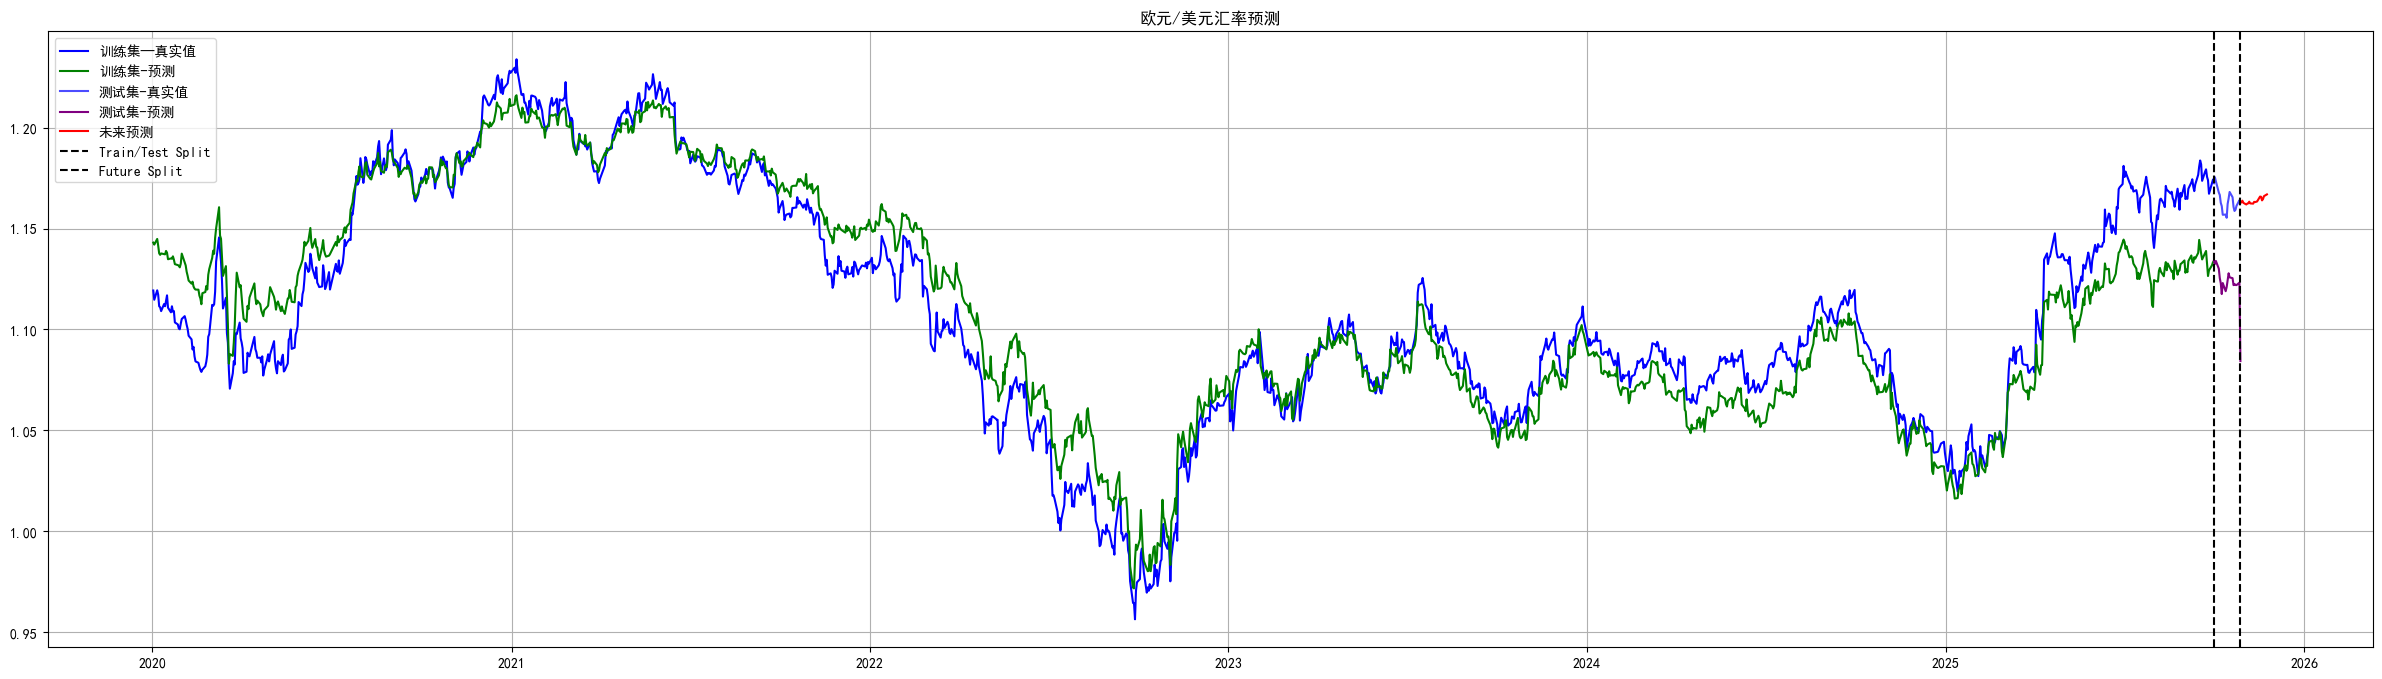

In [10]:

def adjust_predictions(y_test, future_data, column_name=f'{predict_column}_预测'):
    # 将numpy数组转换为pandas Series
    y_test_series = pd.Series(y_test)
    future_predictions = pd.Series(future_data[column_name])
    
    gap = future_predictions.iloc[0] - y_test_series.iloc[-1]
    future_data[f'{column_name}_调整后'] = future_data[column_name] - gap
    print(f"调整差值: {gap}")
    return future_data

future_data = adjust_predictions(y_test, future_data)
future_data = future_data.drop(columns=[f'{predict_column}_预测'])
future_data = future_data.rename(columns={f'{predict_column}_预测_调整后': f'{predict_column}_预测'})


plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data.index, train_data[predict_column], label='训练集—真实值', color='blue')
plt.plot(train_data.index, train_data[f'{predict_column}_预测'], label='训练集-预测', color='green')
plt.plot(test_data.index, test_data[predict_column], label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data.index, test_data[f'{predict_column}_预测'], label='测试集-预测', color='purple')
plt.plot(future_data.index, future_data[f'{predict_column}_预测'], label='未来预测', color='red')

# 添加分割线
plt.axvline(x=test_data.index[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('欧元/美元汇率预测')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 重置索引,将Date从index变为列
train_data_reset = train_data.reset_index()
test_data_reset = test_data.reset_index()
future_data_reset = future_data.reset_index()

# 合并训练集和测试集的欧元/美元数据
merged_df_daily = pd.concat([
    train_data_reset[['Date', '欧元/美元']],
    test_data_reset[['Date', '欧元/美元']]
], sort=False)

# 添加future数据中的预测值
future_data_subset = future_data_reset[['Date', '欧元/美元_预测']]
merged_df_daily = pd.concat([merged_df_daily, future_data_subset], sort=False, join='outer')
# 只保留2024年及以后的数据
merged_df_daily = merged_df_daily[pd.to_datetime(merged_df_daily['Date']).dt.year >= 2024]
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/欧元-美元_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily

,Date,欧元/美元,欧元/美元_预测
18,2025/11/24,NaN,1.166893
17,2025/11/21,NaN,1.166021
16,2025/11/20,NaN,1.164551
15,2025/11/19,NaN,1.163931
14,2025/11/18,NaN,1.165723
...,...,...,...
1027,2024/01/08,1.0946,NaN
1026,2024/01/05,1.0921,NaN
1025,2024/01/04,1.0953,NaN
1024,2024/01/03,1.0919,NaN


In [12]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data_reset['Date'], test_data_reset['Date']]),
    '真实值': pd.concat([train_data_reset['欧元/美元'], test_data_reset['欧元/美元']])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[pd.to_datetime(historical_actual_monthly['Date']).dt.year >= 2023]

# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data_reset[pd.to_datetime(train_data_reset['Date']).dt.year >= 2024]['Date'],
    '预测值': train_data_reset[pd.to_datetime(train_data_reset['Date']).dt.year >= 2024]['欧元/美元_预测']
})

# 2024年及以后测试集预测值
test_pred_2024 = test_data_reset[['Date', '欧元/美元_预测']].copy()
test_pred_2024.rename(columns={'欧元/美元_预测': '预测值'}, inplace=True)

# 未来预测值
future_pred_2024 = pd.DataFrame({
    'Date': future_data_reset['Date'],
    '预测值': future_data_reset['欧元/美元_预测']
})

# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024,
    test_pred_2024,
    future_pred_2024
], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly['Date'] = pd.to_datetime(merged_df_monthly['Date'])
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly = merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')

# 保存成excel
merged_df_monthly.to_excel('eta/欧元-美元_月度数据.xlsx', index=False, float_format='%.6f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,1.163783
33,2025/10/31,1.163800,1.128186
32,2025/09/30,1.173223,1.134276
31,2025/08/31,1.163143,1.129024
30,2025/07/31,1.167687,1.131742
29,2025/06/30,1.151619,1.127434
28,2025/05/31,1.127805,1.110657
27,2025/04/30,1.121395,1.102946
26,2025/03/31,1.080681,1.070716
25,2025/02/28,1.041250,1.039288


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "欧元/美元"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "欧元/美元"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
